In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### im using this dataset :
##### https://www.kaggle.com/datasets/mchirico/montcoalert

#### i hope you enjoy

In [13]:
data = pd.read_csv('/kaggle/input/montcoalert/911.csv')

In [14]:
data.head(5)

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663522 entries, 0 to 663521
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   lat        663522 non-null  float64
 1   lng        663522 non-null  float64
 2   desc       663522 non-null  object 
 3   zip        583323 non-null  float64
 4   title      663522 non-null  object 
 5   timeStamp  663522 non-null  object 
 6   twp        663229 non-null  object 
 7   addr       663522 non-null  object 
 8   e          663522 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 45.6+ MB


In [16]:
addr = data['addr']
desc = data['desc']
data = data.drop(['desc','addr','e'],axis=1)

In [17]:
{col : data[col].unique() for col in data.select_dtypes('object')}

{'title': array(['EMS: BACK PAINS/INJURY', 'EMS: DIABETIC EMERGENCY',
        'Fire: GAS-ODOR/LEAK', 'EMS: CARDIAC EMERGENCY', 'EMS: DIZZINESS',
        'EMS: HEAD INJURY', 'EMS: NAUSEA/VOMITING',
        'EMS: RESPIRATORY EMERGENCY', 'EMS: SYNCOPAL EPISODE',
        'Traffic: VEHICLE ACCIDENT -', 'EMS: VEHICLE ACCIDENT',
        'Traffic: DISABLED VEHICLE -', 'Fire: APPLIANCE FIRE',
        'EMS: GENERAL WEAKNESS', 'Fire: CARBON MONOXIDE DETECTOR',
        'EMS: UNKNOWN MEDICAL EMERGENCY', 'EMS: UNRESPONSIVE SUBJECT',
        'Fire: VEHICLE ACCIDENT', 'EMS: ALTERED MENTAL STATUS',
        'Fire: FIRE ALARM', 'EMS: CVA/STROKE',
        'Traffic: ROAD OBSTRUCTION -', 'EMS: SUBJECT IN PAIN',
        'EMS: HEMORRHAGING', 'EMS: FALL VICTIM', 'EMS: ASSAULT VICTIM',
        'EMS: SEIZURES', 'EMS: MEDICAL ALERT ALARM',
        'EMS: ABDOMINAL PAINS', 'Fire: PUMP DETAIL',
        'Fire: FIRE INVESTIGATION', 'EMS: OVERDOSE', 'EMS: MATERNITY',
        'EMS: UNCONSCIOUS SUBJECT', 'EMS: CHOKING', 

In [18]:
data['Year'] = data['timeStamp'].apply(lambda x: x[0:4]).astype(int)
data['Month'] = data['timeStamp'].apply(lambda x: x[5:7]).astype(int)
data['Day'] = data['timeStamp'].apply(lambda x: x[8:10]).astype(int)
data['Hour'] = data['timeStamp'].apply(lambda x: x[11:13]).astype(int)
data['Minute'] = data['timeStamp'].apply(lambda x: x[14:16]).astype(int)
data['Second'] = data['timeStamp'].apply(lambda x: x[17:19]).astype(int)
data = data.drop('timeStamp',axis=1)

In [19]:
cols = ['twp','zip']
for col in cols : 
    dummie = pd.get_dummies(data[col],prefix=col).astype(int)
    data = pd.concat([data,dummie],axis=1)
    data = data.drop(col,axis=1)

In [20]:
def process_text (text):
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(text)
    text = tokenizer.texts_to_sequences(text)
    max_length = np.max(list(map(lambda x: len(x),text)))
    
    text = pad_sequences(text,maxlen=max_length,padding='post')
    return text , max_length

In [21]:
desc , len_desc = process_text(desc)

In [22]:
addr , len_addr = process_text(addr)

In [23]:
data['title'] = data['title'].apply(lambda x : re.search(r'^\w+',x).group(0))

In [24]:
title_mapping = {'EMS': 0 ,'Fire' : 1 , 'Traffic' : 2}
data['title'] = data['title'].replace(title_mapping)

In [25]:
y = data['title'].copy()
x = data.drop('title',axis=1).copy()

In [26]:
x_train , x_test , desc_train , desc_test , addr_train , addr_test , y_train , y_test = train_test_split(
    x,desc,addr,y,train_size=0.745,random_state=13)

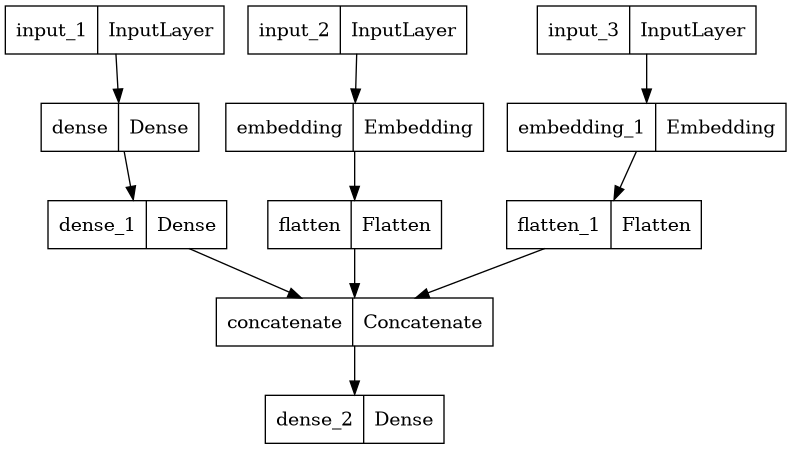

In [27]:
x_inputs = tf.keras.Input(shape=(x_train.shape[1],))
x_dense = tf.keras.layers.Dense(128,activation='relu')(x_inputs)
x_dense = tf.keras.layers.Dense(128,activation='relu')(x_dense)

desc_input = tf.keras.Input(shape=(desc_train.shape[1],))
desc_embedding = tf.keras.layers.Embedding(
    input_dim=10000
    ,output_dim=64
    ,input_length=len_desc
)(desc_input)

desc_flatten = tf.keras.layers.Flatten()(desc_embedding)

addr_input = tf.keras.Input(shape=(addr_train.shape[1],))
addr_embedding = tf.keras.layers.Embedding(
    input_dim=10000
    ,output_dim=64
    ,input_length=len_addr
)(addr_input)

addr_flatten = tf.keras.layers.Flatten()(addr_embedding)

concat = tf.keras.layers.concatenate([x_dense,desc_flatten,addr_flatten])

output = tf.keras.layers.Dense(3,activation='softmax')(concat)

model = tf.keras.Model(inputs=[x_inputs,desc_input,addr_input],outputs=output)

tf.keras.utils.plot_model(model)

In [30]:
model.compile(
    optimizer='adam'
    ,loss='sparse_categorical_crossentropy'
    ,metrics=['accuracy']
)

hist = model.fit(
    [x_train,desc_train,addr_train]
    ,y_train,
    validation_split=0.2
    ,batch_size=32
    ,epochs=5
    ,callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2,restore_best_weights=True)
)

Epoch 1/20
12359/12359 [==============================] - 64s 5ms/step - loss: 4.3499e-10 - accuracy: 1.0000 - val_loss: 1.9249e-07 - val_accuracy: 1.0000
Epoch 2/20
12359/12359 [==============================] - 50s 4ms/step - loss: 3.5149e-10 - accuracy: 1.0000 - val_loss: 1.2375e-07 - val_accuracy: 1.0000
Epoch 3/20
12359/12359 [==============================] - 50s 4ms/step - loss: 2.7281e-10 - accuracy: 1.0000 - val_loss: 1.1344e-07 - val_accuracy: 1.0000


In [34]:
results = model.evaluate([x_test,desc_test,addr_test],y_test,verbose=0)

In [36]:
print('Model Accuracy {:.3f}'.format(results[1]))

Model Accuracy 1.000
